In [2]:
# import des modules nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from distinctipy import distinctipy
from matplotlib.font_manager import FontProperties
from matplotlib import rc
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import clear_output, display
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.formula.api as statsapi
import statsmodels as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import xlrd as xlrd

# Modifier les paramètres d'affichage de la sortie des commandes dans Jupyter
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

# import de la police Garamond
garamond_font = FontProperties(fname="C:/Windows/Fonts/GARA.TTF",size=14)
timesnewroman_font = FontProperties(fname="C:/Windows/Fonts/TIMES.TTF",size=14)

import des fichiers de données et des fichiers d'url pour récupérer les champs "Modifié le" et Notices associée".
Etant donné que les résultats de recherche ne peuvent pas contenir plus de 10000 enregistrements nous avons morcellé la recherche en 4 requêtes :
Il y a 4414 résultats qui correspondent à /France/Paris et Ile de France /Panthéon Sorbonne P1
Il y a 6335 résultats qui correspondent à /France/Paris et Ile de France /Tout saut Paris Panthéon Sorbonne P1
Il y a 7411 résultats qui correspondent à /France/Tout sauf Paris et Ile de France
Il y a 60 résultats qui correspondent à /Italie, Suisse et Non Renseignés
Soit un total de 18220 au lieu de 18217 résultats dans TRHAA.


In [3]:


df_data_temp_4414 = pd.read_excel("input/TRHAA/DATA for Fr_ParisIDF_Sorbonne_4414.xlsx", sheet_name=0)
df_data_temp_6335 = pd.read_excel("input/TRHAA/DATA for Fr_ParisIDF_TtSaufsorbonne_6335.xlsx", sheet_name=0)
df_data_temp_7411 = pd.read_excel("input/TRHAA/DATA for Fr_TtSaufParis_7411.xlsx",sheet_name=0)
df_data_temp_60 = pd.read_excel("input/TRHAA/DATA for TtSaufFrNonRenseignes_60.xlsx",sheet_name=0)

df_url_temp_6335 = pd.read_excel("input/TRHAA/URL_List_Fr_ParisIDF_TtSaufSorbonne_6335.xlsx",sheet_name=0)
df_url_temp_4414 = pd.read_excel("input/TRHAA/URL_List_Fr_ParisIDF_Sorbonne_4414.xlsx",sheet_name=0)
df_url_temp_7411 = pd.read_excel("input/TRHAA/URL_List_Fr_TtSaufParis_7411.xlsx",sheet_name=0)
df_url_temp_60 = pd.read_excel("input/TRHAA/URL_List_TtSaufFrance_NonRenseigne_60.xlsx",sheet_name=0)


Croisement des dataframe DATA et URL sur la clé "URL de la page" pour avoir l'ensemble des données pour chaque

In [4]:
# Merge des fichiers

# Column bind des logs et questionnaires
df_4414_temp = pd.merge(df_data_temp_4414, df_url_temp_4414,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_6335_temp = pd.merge(df_data_temp_6335, df_url_temp_6335,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_7411_temp = pd.merge(df_data_temp_7411, df_url_temp_7411,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_60_temp = pd.merge(df_data_temp_60, df_url_temp_60,on=['Original_URL'],how='outer',suffixes=('','_url'))
print("Shape de df_4414_temp: ", df_4414_temp.shape)
print("shape de df_6335_temp: ", df_6335_temp.shape)
print("Shape de df_7411_temp: ", df_7411_temp.shape)
print("Shape de df_60_temp: ", df_60_temp.shape)


Shape de df_4414_temp:  (4414, 23)
shape de df_6335_temp:  (6335, 23)
Shape de df_7411_temp:  (7411, 23)
Shape de df_60_temp:  (60, 23)


Le nombre de colonnes est identique entre tous les fichiers (23), le nombre de lignes correspond aux nombres prévus donc on peut concaténer l'ensemble des dataframes pour obtenir un seul dataframe.

In [5]:
# Concaténation des dataframes

df_tmp_1et2 = pd.concat([df_4414_temp,df_6335_temp], ignore_index=True)
df_tmp_3et4=pd.concat([df_7411_temp,df_60_temp], ignore_index=True)
df_trhaa_initial = pd.concat([df_tmp_1et2,df_tmp_3et4], ignore_index=True)

# Vérification du format
print("Shape de df_tmp: ", df_trhaa_initial.shape)

# Affichage des colonnes et renommage des colonnes ayant des noms génériques

print("Colonnes: ", df_trhaa_initial.columns)
df_trhaa_initial.rename(columns={"Field3": "ModifieLe","Field4": "NoticeAssocieeA"},inplace=True)
print("Colonnes: ", df_trhaa_initial.columns)


Shape de df_tmp:  (18220, 23)
Colonnes:  Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'Field3', 'Field4'],
      dtype='object')
Colonnes:  Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA'],
      dtype='obje

Pré-traitement des données. Analyse des colonnes qui contiennent une valeur unique pour suppression du champ ultérieurement. A priori Illustration, RoleAuteurPrincipal

Comparaison des champs SoutenanceDateDebut et SoutenanceDateFin. Si identiques on n'en conserve qu'une seule.
Idem pour les champs TitreOuvrage et Titre


In [6]:
# Info
df_trhaa_initial.info()

df_trhaa_initial.isna().sum()

pd.DataFrame.nunique(df_trhaa_initial)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Illustration                       18202 non-null  object
 1   TypeDocument                       18202 non-null  object
 2   TitreOuvrage                       18199 non-null  object
 3   Ref_Complete                       17566 non-null  object
 4   LangueDocument                     17981 non-null  object
 5   RoleAuteurPrincipal                18194 non-null  object
 6   TypeMemoire                        17966 non-null  object
 7   AnneeSoutenance                    16051 non-null  object
 8   SoutenanceDateDebut                15678 non-null  object
 9   SoutenanceDateFin                  15913 non-null  object
 10  AuteurPrincipal                    18201 non-null  object
 11  TAuteurs                           18202 non-null  object
 12  Doma

Illustration                             1
TypeDocument                             6
TitreOuvrage                         18108
Ref_Complete                         17562
LangueDocument                           5
RoleAuteurPrincipal                      3
TypeMemoire                             19
AnneeSoutenance                        136
SoutenanceDateDebut                     91
SoutenanceDateFin                      233
AuteurPrincipal                      15035
TAuteurs                             17050
DomainesDeRecherche                   1692
UniversitesDeSoutenancePrincipale       76
UniversitesDeSoutenance                 87
Original_URL                         18215
GestionNotice                          139
Indexation                            5021
Commentaires                             6
Titre                                18109
Field1_links                         18215
ModifieLe                              102
NoticeAssocieeA                          4
dtype: int6

Il n'y a qu'un seul champ qui n'a qu'une seule valeur : Illustration

<Axes: >

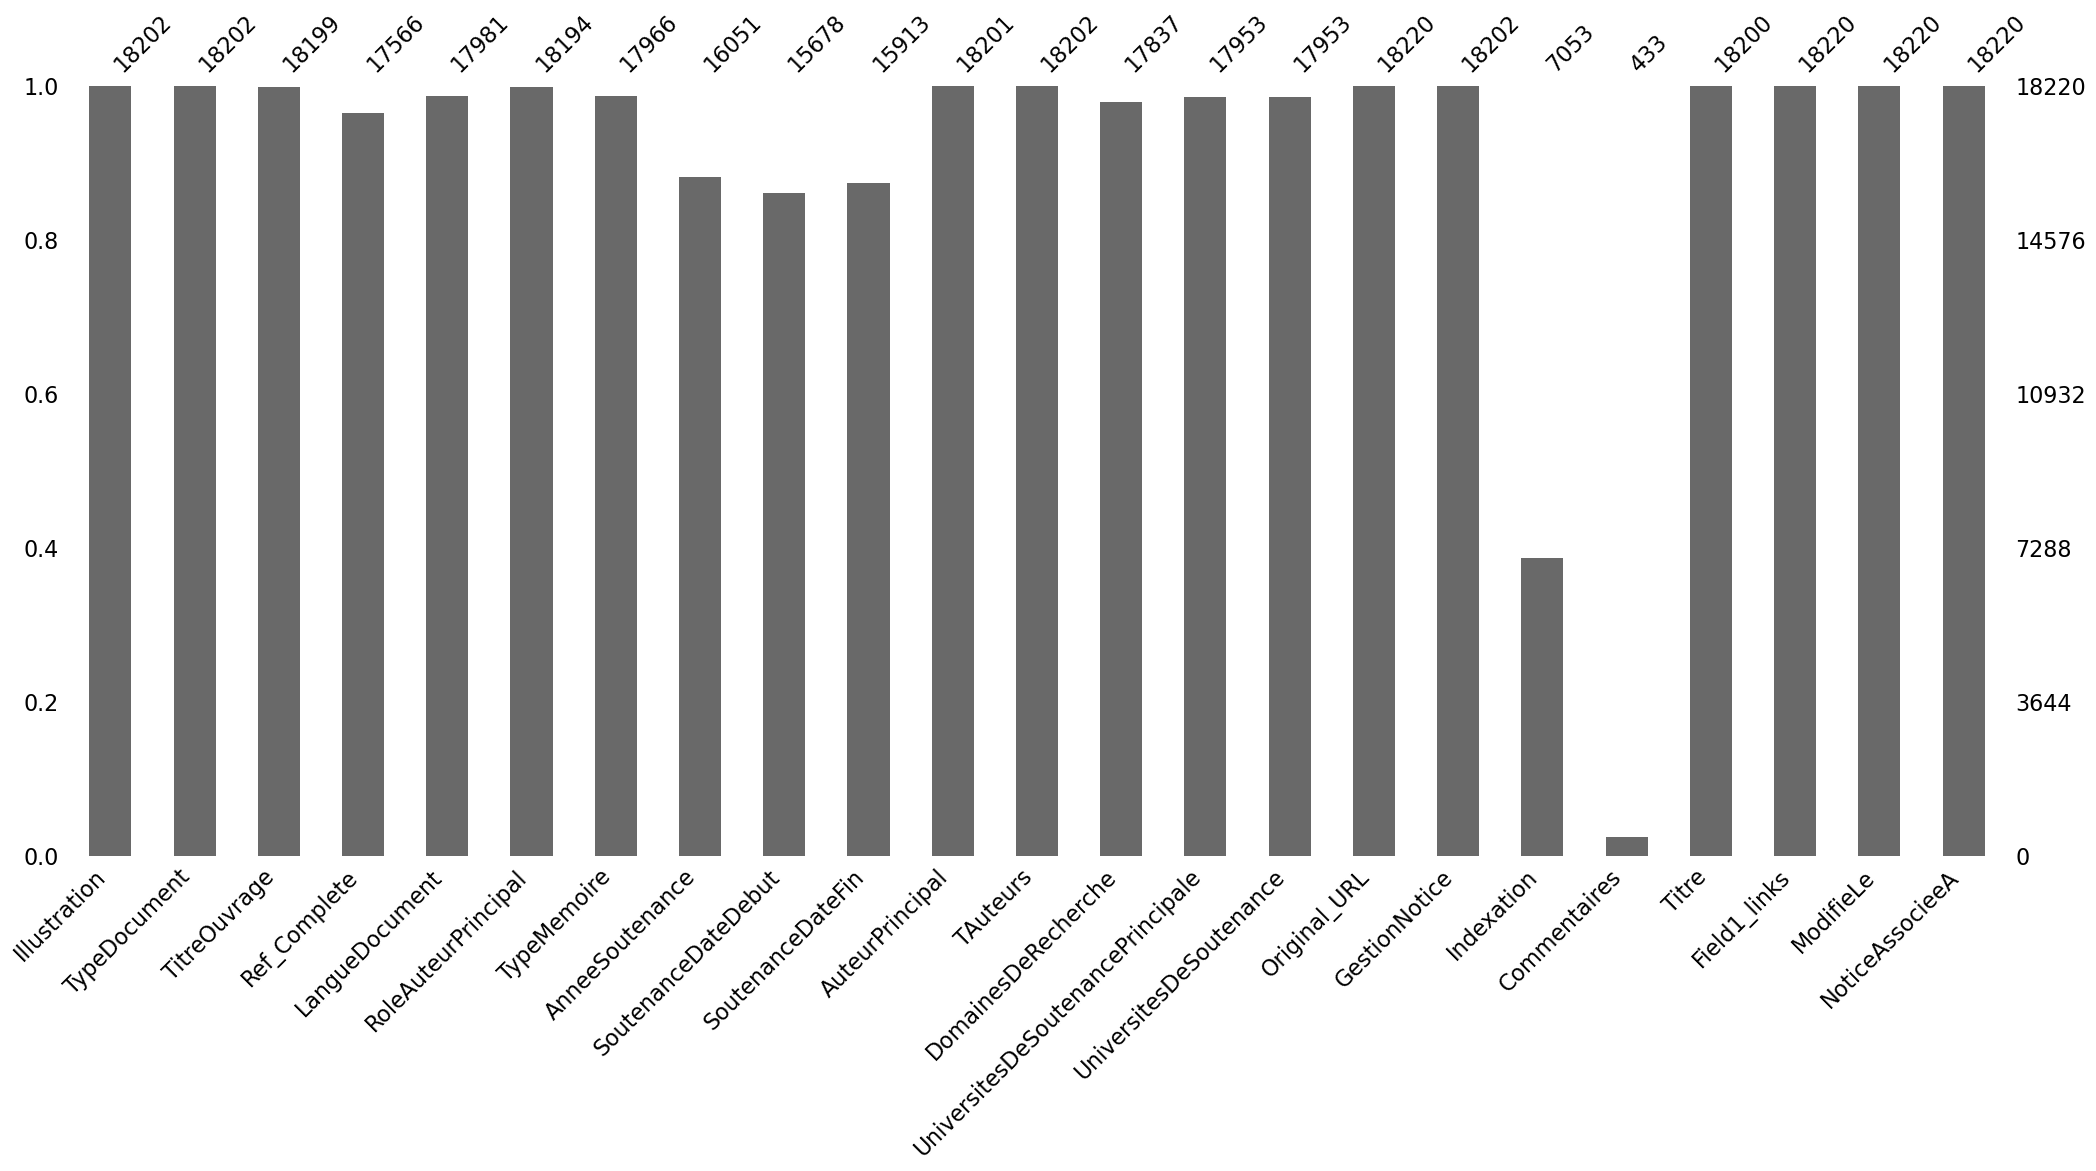

In [7]:
# Analyse colonnes
msno.bar(df_trhaa_initial)

# Comparaison des champs TitreOuvrage et Titre
#df_comp2 = (df_trhaa_tmp["TitreOuvrage"]==df_trhaa_tmp["Titre"])
#print(df_comp2.columns)
#print(df_comp2[""].all())

#if (df_comp2[""].all()) == "True":
#    print("les colonnes Titre et TitreOuvrage sont égales")
#else:
#    print("elles sont différentes")

# Nettoyage des champs inutiles pour obtenir df_trhaa_initial
#df_trhaa_initial_v2 = df_trhaa_initial.drop(['Illustration','RoleAuteurPrincipal','Titre','SoutenanceDateFin'])

# Renommage colonne SoutenanceDateDebut
#df_trhaa_initial_v2.rename(columns={'SoutenanceDateDebut':'DateSoutenance'})

In [8]:
# Remplissage des champs SoutenanceDateDebut et Fin à partir de la colonne AnneeSoutenance

import re

ligne = "Année de soutenance:1969-1969"

pattern = r"(\d{4})(?:\s*-\s*(\d{4}))?"

matches = re.findall(pattern, ligne)
for match in matches:
    # Si la deuxième date est absente, le groupe de capture 2 sera vide (None).
    # Vous pouvez le remplacer par une valeur par défaut si nécessaire.
    debut = match[0]
    fin = match[1] if match[1] else ""  # Utilisez une valeur par défaut ici si nécessaire
    print("Début:", debut, "Fin:", fin)

# Comparaison des champs TitreOuvrage et Titre
#df_comp2 = (df_trhaa_tmp["TitreOuvrage"]==df_trhaa_tmp["Titre"])
#print(df_comp2.columns)
#print(df_comp2[""].all())

#if (df_comp2[""].all()) == "True":
#    print("les colonnes Titre et TitreOuvrage sont égales")
#else:
#    print("elles sont différentes")


Début: 1969 Fin: 1969


Visualisation des différentes valeurs de certains champs : TypeDocument, LangueDocument, RoleAuteurPrincipal, TypeMemoire

In [9]:
print(df_trhaa_initial.groupby(["TypeDocument"])["TypeDocument"].count())

# on trouve quasiment exclusivement des mémoires (77,80%) /18202) et des thèses (22,05%)

TypeDocument
DPLG                                     5
contribution à un ouvrage                1
mémoire                              14169
ouvrage                                 11
thèse                                 4015
travail personnel de fin d'études        1
Name: TypeDocument, dtype: int64


In [10]:
print(df_trhaa_initial.groupby(["LangueDocument"])["LangueDocument"].count())

# Essentiellement des travaux en langue française

LangueDocument
Allemand         2
Anglais          4
Espagnol         1
Français     17973
Portugais        1
Name: LangueDocument, dtype: int64


In [11]:
print(df_trhaa_initial.groupby(["RoleAuteurPrincipal"])["RoleAuteurPrincipal"].count())

# Les auteurs principaux sont mentionnés (18182 sur 18202) quasiment tout le temps sauf une dizaine de fois où, très probablement, une erreur de saisie a mentionné le directeut de mémoire à la place

print(df_trhaa_initial[df_trhaa_initial["RoleAuteurPrincipal"]=="directeur de mémoire"][["Ref_Complete","AuteurPrincipal"]])
print(df_trhaa_initial[df_trhaa_initial["RoleAuteurPrincipal"]=="directeur de thèse"][["Ref_Complete","AuteurPrincipal"]])

RoleAuteurPrincipal
auteur                  18182
directeur de mémoire       11
directeur de thèse          1
Name: RoleAuteurPrincipal, dtype: int64
                                            Ref_Complete       AuteurPrincipal
1321   Gallier, Valentine. La Fuite de Gradlon : entr...     Méneux, Catherine
1577   Posca, Francesca Romana. Les femmes dans les m...       Dagen, Philippe
1606   Gremel, Clémence. L’Estampe et l’affiche (1897...     Méneux, Catherine
1607   Ghnadour, Yasmine. En quête d’identité. La col...     Méneux, Catherine
3783   Langlois, Amandine. Patrimoine, politiques cul...     Méneux, Catherine
3784   Brault, Julie. Le périodique illustré Cocorico...        Gispert, Marie
3785   Garcia, Constance. Désaccord d’interprétation ...        Gispert, Marie
3792   Garden, Morgane. Les « cadres-souvenirs » des ...     Pernoud, Emmanuel
3793   Vasseur, Delphine. Les représentations de la f...     Méneux, Catherine
9131   Palmieri, Fiorella. Les Modistes parisiennes d...    

In [12]:
print(df_trhaa_initial.groupby(["TypeMemoire"])["TypeMemoire"].count())

TypeMemoire
Habilitation à diriger des recherches                    61
Mémoire de 2e cycle de l'Ecole du Louvre                316
Mémoire de 3e cycle de l'Ecole du Louvre (Thèse)         91
Mémoire de DEA                                         1847
Mémoire de DESS                                           1
Mémoire de DRA                                           71
Mémoire de l'IFROA                                       62
Mémoire de master professionnel 1re année                32
Mémoire de master professionnel 2e année                139
Mémoire de master recherche 1re année                  4164
Mémoire de master recherche 2e année                   3214
Mémoire de maîtrise                                    4177
Mémoire de maîtrise de sciences et techniques (MST)      15
Thèse d'État                                              2
Thèse de 3e cycle                                         2
Thèse de doctorat                                        29
Thèse de l'Ecole des chartes

Vérification si les thèses inscrites ou soutenues (TypeMémoire) sont bien des Thèses (TypeDocument)

Si TypeMemoire est thèses inscrites ou soutenues, et TypeDocument est thèse alors verifThese = 1. On a 4015 thèses dans TypeDocument, et 1948 thèses inscrites, 1784 thèses soutenues dans TypeMémoire, en supposant qu'une thèse soutenue, et donc préalablement inscrite, n'est comptabilisée que comme thèse soutenue. Résultat plutôt bon avec 92% de correspondance (3729 / 4015). On peut donc 1) Ajouter des champs TheseInscrite et TheseSoutenue sur le statut des thèses 2) Poursuivre avec la simplification des TypeMemoire, en particulier les thèses inscrites ou soutenues qui sont très probablement des thèses de doctorat

In [13]:
# valeurs par défaut
df_trhaa_initial["verifThese"] = 0

# debug
print(len(df_trhaa_initial["TypeMemoire"]))
#print(range(len(df_trhaa_initial["TypeMemoire"])))

# parcours
for i in range(len(df_trhaa_initial["TypeMemoire"])):
    serieRow = df_trhaa_initial.iloc[i]
    itemTypeMemoire = serieRow.loc["TypeMemoire"]
    itemTypeDocument = serieRow.loc["TypeDocument"]
    #print("TypeMemoire: ", itemTypeMemoire, "TypeDocument: ", itemTypeDocument)
    if ((itemTypeMemoire == "Thèse inscrite") or (itemTypeMemoire == "Thèse soutenue")) and (itemTypeDocument == "thèse"):
        df_trhaa_initial["verifThese"].iloc[i] = "thèse confirmée"
print("Thèses confirmées: ", df_trhaa_initial.groupby(["verifThese"])["verifThese"].count())


18220


/var/folders/8g/9w5gh8y54xd9jss52_tlythr0000gn/T/ipykernel_611/3177438231.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trhaa_initial["verifThese"].iloc[i] = "thèse confirmée"


Thèses confirmées:  verifThese
0                  14491
thèse confirmée     3729
Name: verifThese, dtype: int64


Listons les enregistements marqués comme thèse (TypeDocument) mais qui ne le sont pas à priori (TypeMemoire)

In [14]:
# init
df_trhaa_initial["verifNONThese"] = 0

# parcours
for i in range(len(df_trhaa_initial["TypeMemoire"])):
    serieRow = df_trhaa_initial.iloc[i]
    itemTypeMemoire = serieRow.loc["TypeMemoire"]
    itemTypeDocument = serieRow.loc["TypeDocument"]
    #print("TypeMemoire: ", itemTypeMemoire, "TypeDocument: ", itemTypeDocument)
    if ((itemTypeMemoire != "Thèse inscrite") and 
        (itemTypeMemoire != "Thèse soutenue") and 
        (itemTypeMemoire != "Thèse de doctorat") and 
        (itemTypeMemoire != "Habilitation à diriger des recherches") and 
    (itemTypeDocument == "thèse")):
        df_trhaa_initial["verifNONThese"].iloc[i] = "thèse NON confirmée"
print("Thèses NON confirmées: ", df_trhaa_initial.groupby(["verifNONThese"])["verifNONThese"].count())




/var/folders/8g/9w5gh8y54xd9jss52_tlythr0000gn/T/ipykernel_611/282877332.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trhaa_initial["verifNONThese"].iloc[i] = "thèse NON confirmée"


Thèses NON confirmées:  verifNONThese
0                      18024
thèse NON confirmée      196
Name: verifNONThese, dtype: int64


Ajout de champs TheseInscrite et TheseSoutenue

In [15]:
# valeurs par défaut
df_trhaa_initial["TheseInscrite"] = "False"
df_trhaa_initial["TheseSoutenue"] = "False"

# maj sous conditions
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Thèse inscrite", "TheseInscrite"] = "True"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Thèse soutenue", "TheseSoutenue"] = "True"


 Pour nous permettre par la suite d'analyser les parcours universitaires des étudiants nous simplifions le champ TypeMemoire :
 Mémoires : M2 recherche, M2 Pro, M1 Recherche, M1 Pro
 Thèses : Thèse de 3e cycle, HDR, Thèse de doctorat

In [49]:
# valeurs par défaut
df_trhaa_initial["TypeMemoireThese"] = np.nan
df_trhaa_initial.reset_index()

# maj sous conditions # thèses
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Thèse inscrite", "TypeMemoireThese"] = "These de doctorat"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Thèse soutenue", "TypeMemoireThese"] = "These de doctorat"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Thèse d'État", "TypeMemoireThese"] = "These de doctorat"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Thèse de l'Ecole des chartes", "TypeMemoireThese"] = "These de 3e cycle"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Thèse de 3e cycle", "TypeMemoireThese"] = "These de 3e cycle"

# maj sous conditions # mémoires
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Habilitation à diriger des recherches", "TypeMemoireThese"] = "HDR"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de 2e cycle de l'Ecole du Louvre", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de 3e cycle de l'Ecole du Louvre (Thèse)", "TypeMemoireThese"] = "These de 3e cycle"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de DEA", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de DESS", "TypeMemoireThese"] = "M2 Pro"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de DRA", "TypeMemoireThese"] = "M2 Recherche" # DRA == DEA ??
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de l'IFROA", "TypeMemoireThese"] = "M2 Pro" # M2 plutôt que M1 car clôt un cycle
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de master professionnel 1re année", "TypeMemoireThese"] = "M1 Pro"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de master professionnel 2e année", "TypeMemoireThese"] = "M2 Pro"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de master recherche 1re année", "TypeMemoireThese"] = "M1 Recherche"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de master recherche 2e année", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de maîtrise", "TypeMemoireThese"] = "M1 Recherche"
df_trhaa_initial.loc[df_trhaa_initial["TypeMemoire"] == "Mémoire de maîtrise de sciences et techniques (MST)", "TypeMemoireThese"] = "M2 Pro"

print(df_trhaa_initial[["Illustration","TypeMemoireThese"]].groupby("TypeMemoireThese")["TypeMemoireThese"].count())

TypeMemoireThese
HDR                    61
M1 Pro                 32
M1 Recherche         8341
M2 Pro                217
M2 Recherche         5448
These de 3e cycle     104
These de doctorat    3734
Name: TypeMemoireThese, dtype: int64


nous ajoutons un champ que nous pourrons utiliser comme clé primaire. Il est construit à partir du champ Field1_links et contient une référence unique à chaque page.

In [17]:
from urllib.parse import urlparse

# valeurs par défaut
df_trhaa_initial["refPage"] = np.nan

# décomposition de Field1_links
for ligne in range(len(df_trhaa_initial["Field1_links"])):
    #print(df_trhaa_initial["Field1_links"][ligne])
    path = urlparse(df_trhaa_initial["Field1_links"][ligne]).path
    df_trhaa_initial["refPage"][ligne] = path.split('/')[-1]

print(df_trhaa_initial["refPage"].head(3))

/var/folders/8g/9w5gh8y54xd9jss52_tlythr0000gn/T/ipykernel_611/3232056135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trhaa_initial["refPage"][ligne] = path.split('/')[-1]


0    c89d05f4-f622-409d-9f1e-eede55803f3a
1    7280af88-ff65-43ed-8b94-ff94e3686180
2    0537482c-b996-43f6-bd0c-b622a6de31c7
Name: refPage, dtype: object


Distinction des différents domaines de recherche

In [18]:
print(df_trhaa_initial.columns)

print(df_trhaa_initial["DomainesDeRecherche"][2])

Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA', 'verifThese', 'verifNONThese', 'TheseInscrite', 'TheseSoutenue',
       'TypeMemoireThese', 'refPage'],
      dtype='object')
Domaine(s) de recherche : 
       
              Art et archéologie du 20e-21e siècles
             
              Art et archéologie de la civilisation japonaise


Il y a 58 domaines de recherches différents pour l'ensemble des 18000 fiches. Ce chiffre semble montrer que les entrées de la base de données sont contrôlées pour cette donnée. Une catégorisation avec moins de valeurs différentes utilisant de plus larges domaines de recherches sera nécessaire pour rendre cette données exploitable. A placer en annexe dans le rapport.

In [34]:
# lib
import re

#
df_trhaa_DomaineRecherche = pd.DataFrame([])
for i in range(len(df_trhaa_initial["DomainesDeRecherche"])):
    try:
        strDomainesComplets = df_trhaa_initial["DomainesDeRecherche"][i].split(":")
        strDomaines = strDomainesComplets[1:][0]
        lstDomaines = strDomaines[2:].split("\n")
        for j in range(len(lstDomaines)):
            strpDomaines = lstDomaines[j].strip()
            if len(strpDomaines) != 0:
                nouvelle_ligne = pd.DataFrame({'ListeDomaines': [strpDomaines]})
                df_trhaa_DomaineRecherche = pd.concat([df_trhaa_DomaineRecherche,nouvelle_ligne], ignore_index=True)
    except:
        print("exception")
    
df_trhaa_DomaineRecherche.reset_index()
print("Nb de domaines de recherche distincts: ",len(df_trhaa_DomaineRecherche.groupby("ListeDomaines")))
    

exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception
exception


58

Travail sur les Universités

In [41]:
df2 = df_trhaa_initial.groupby("UniversitesDeSoutenancePrincipale").count()
print("Quelques unes des universités \n\n", df2["Illustration"].sort_values(ascending=False).reset_index().head(5))
print("\nNb d'Universités distinctes: ", len(df2.groupby("UniversitesDeSoutenancePrincipale")))
#


Quelques unes des universités 

         UniversitesDeSoutenancePrincipale  Illustration
0  Université Panthéon-Sorbonne - Paris I          4399
1    Université Paris-Sorbonne - Paris IV          3360
2                         Ecole du Louvre          1184
3            Université Lumière - Lyon II           915
4               Université Paris-Nanterre           886

Nb d'Universités distinctes:  76


In [22]:
# Lister tous les enregistrements de df_trhaa_initial qui sont UniversitesDeSoutenancePrincipale = Ecole du Louvre
# et lister les differentes valeurs de TypeMemoire. On fait ça pour les 3 plus importantes universités

df = df_trhaa_initial[df_trhaa_initial["UniversitesDeSoutenancePrincipale"]=="Ecole du Louvre"]
print(df.groupby(["TypeMemoire"])[["TypeMemoire"]].count())


                                                  TypeMemoire
TypeMemoire                                                  
Mémoire de 2e cycle de l'Ecole du Louvre                  314
Mémoire de 3e cycle de l'Ecole du Louvre (Thèse)           91
Mémoire de DRA                                             71
Mémoire de master professionnel 2e année                   58
Mémoire de master recherche 1re année                     502
Mémoire de master recherche 2e année                      145
Thèse inscrite                                              2


In [23]:
# Lister tous les enregistrements de df_trhaa_initial qui sont UniversitesDeSoutenancePrincipale = Ecole du Louvre
# et lister les differentes valeurs de TypeMemoire. On fait ça pour les 3 plus importantes universités

df = df_trhaa_initial[df_trhaa_initial["UniversitesDeSoutenancePrincipale"]=="Université Panthéon-Sorbonne - Paris I"]
print(df.groupby(["TypeMemoire"])[["TypeMemoire"]].count())


                                          TypeMemoire
TypeMemoire                                          
Habilitation à diriger des recherches              11
Mémoire de DEA                                    623
Mémoire de master professionnel 2e année           10
Mémoire de master recherche 1re année             797
Mémoire de master recherche 2e année              436
Mémoire de maîtrise                              1092
Thèse de doctorat                                   4
Thèse inscrite                                    658
Thèse soutenue                                    768


In [24]:
# Lister tous les enregistrements de df_trhaa_initial qui sont UniversitesDeSoutenancePrincipale = Ecole du Louvre
# et lister les differentes valeurs de TypeMemoire. On fait ça pour les 3 plus importantes universités

df = df_trhaa_initial[df_trhaa_initial["UniversitesDeSoutenancePrincipale"]=="Université Paris-Sorbonne - Paris IV"]
print(df.groupby(["TypeMemoire"])[["TypeMemoire"]].count())


                                           TypeMemoire
TypeMemoire                                           
Habilitation à diriger des recherches               19
Mémoire de 2e cycle de l'Ecole du Louvre             1
Mémoire de DEA                                     442
Mémoire de master professionnel 1re année            1
Mémoire de master recherche 1re année              986
Mémoire de master recherche 2e année               820
Mémoire de maîtrise                                627
Thèse de 3e cycle                                    1
Thèse de doctorat                                    3
Thèse inscrite                                     215
Thèse soutenue                                     244


Distribution des dates de dernière modification. Ajout d'un champ mois et année

In [25]:
# Nouvelle colonne avec uniquement la date de dernière modification
df_trhaa_initial[["Bla","DateModif"]] = df_trhaa_initial.ModifieLe.str.split(":", expand=True)
df_trhaa_initial["DateModif"] = df_trhaa_initial["DateModif"].str.replace(' ','')
df_trhaa_initial["dtModifieLe"] = pd.to_datetime(df_trhaa_initial["DateModif"], format='%d/%m/%Y')
df_trhaa_initial.drop(columns=["Bla","DateModif"], inplace=True)


In [26]:
# Nettoyage des DF

colonnes_a_supprimer = ["nb_documents2"]
#df_trhaa_initial.drop(columns=colonnes_a_supprimer, inplace=True)
print(df_trhaa_initial.columns)



Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA', 'verifThese', 'verifNONThese', 'TheseInscrite', 'TheseSoutenue',
       'TypeMemoireThese', 'refPage', 'dtModifieLe'],
      dtype='object')


In [27]:
# Groupby par Année et Mois
df_trhaa_initial["nb_documents"] = df_trhaa_initial[["Illustration"]].copy()
df_trhaa_grouped = df_trhaa_initial.groupby(["dtModifieLe"]).count().reset_index()
df_trhaa_grouped = df_trhaa_grouped.sort_values("dtModifieLe",ascending=True)
print("Quelques lignes de la distribution \n", df_trhaa_grouped[["dtModifieLe","nb_documents"]])

# description de la distribution
print("Description de la distribution \n", df_trhaa_grouped["nb_documents"].describe())

# on vérifie bien la somme de tous les nombres = 18202
print("Somme de tous les nombres \n", df_trhaa_grouped["nb_documents"].sum())



Quelques lignes de la distribution 
     dtModifieLe  nb_documents
0    2018-07-04             1
1    2018-10-08             1
2    2019-01-04            25
3    2019-10-09             1
4    2019-12-05             3
..          ...           ...
97   2023-04-25             1
98   2023-05-03             1
99   2023-05-16             4
100  2023-05-17             1
101  2023-06-08             1

[102 rows x 2 columns]
Description de la distribution 
 count     102.000000
mean      178.450980
std      1081.427784
min         1.000000
25%         1.250000
50%         5.000000
75%        13.750000
max      8046.000000
Name: nb_documents, dtype: float64
Somme de tous les nombres 
 18202


Il y a 102 dates de modification différentes. Cela semble peu par rapport au nombre de lignes dans les données sources. En outre 

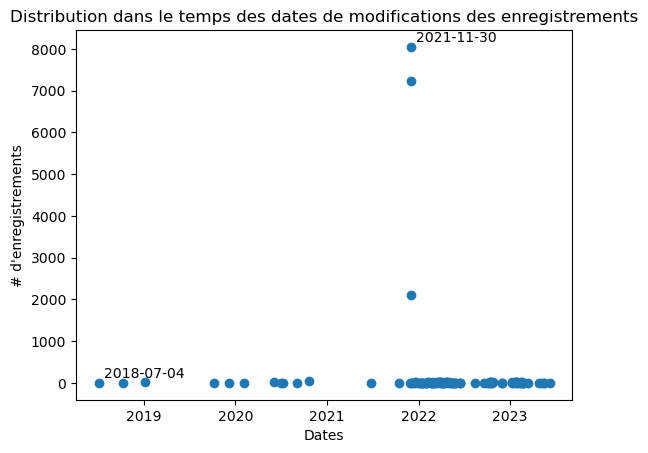

In [28]:
# lib
from datetime import datetime
#dtpoint = datetime("%d-%m-%Y")

# Afficher la distribution du nombre de documents
fig,ax = plt.subplots()

#df_trhaa_grouped.scatterplot( df_trhaa_grouped["dtModifieLe"], df_trhaa_grouped["nb_documents"])
ax.scatter(df_trhaa_grouped["dtModifieLe"], df_trhaa_grouped["nb_documents"])
dtpoint1 = datetime.strptime("2018-07-04", "%Y-%m-%d")
dtpoint8046 = datetime.strptime("2021-11-30", "%Y-%m-%d")
ax.annotate("2018-07-04", xy=(dtpoint1,1), xytext = (5,5), textcoords = "offset pixels")
ax.annotate("2021-11-30", xy=(dtpoint8046,8046), xytext = (5,5), textcoords = "offset pixels")
plt.title("Distribution dans le temps des dates de modifications des enregistrements")
plt.xlabel("Dates")
plt.ylabel("# d'enregistrements")
plt.show()

Text(0, 0.5, "# d'enregistrements")

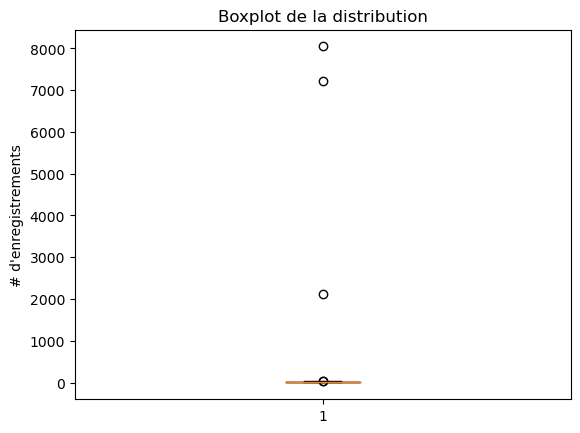

In [29]:
# Afficher

plt.boxplot(df_trhaa_grouped["nb_documents"])
plt.title("Boxplot de la distribution")
plt.ylabel("# d'enregistrements")

Quel champ utiliser pour les dates de soutenance ? Existe t-il des différences entre les champs date de début de soutenance et date de fin de soutenance ? La réponse est non à 86%, on propose d'utiliser la date de fin de soutenance.

In [89]:
# init
df_comp_dates = pd.DataFrame([])

# Comparaison des champs
df_comp_dates["Resultat_Comp"] = (df_trhaa_initial["SoutenanceDateDebut"]==df_trhaa_initial["SoutenanceDateDebut"])
#print(df_comp_dates.reset_index())
print("Info: ",df_comp_dates.info())
print("index: ",df_comp_dates.index)
print("Cols: ",df_comp_dates.columns)
#print("colonnes: ",df_comp_dates.info(), "\n")
print("Nb de valeurs identiques: ", df_comp_dates["Resultat_Comp"].sum())
print("Nb de valeurs totales: ", df_comp_dates["Resultat_Comp"].count())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Resultat_Comp  18220 non-null  bool 
dtypes: bool(1)
memory usage: 17.9 KB
Info:  None
index:  RangeIndex(start=0, stop=18220, step=1)
Cols:  Index(['Resultat_Comp'], dtype='object')
Nb de valeurs identiques:  15678
Nb de valeurs totales:  18220


Etant donné que nous n'avons pas la date d'insertion des enregistrements dans la base mais seulement la date de dernière modification, nous faisons l'approximation que la date de fin de soutenance correspond à la date d'insertion à un an près.
En outre les dates de début et de fin de soutenance sont proches ?
Dans la suite de cette étude nous utiliserons la date de fin de soutenance uniquement.

Combien les étudiants ont réalisés de mémoires ou de thèses, toutes filières confondues, toutes université confondues ?

In [32]:
# init
df_trhaa_initial["NbDocParEtudiant"] = 0

# afficher la distribution des # de documents (mémoires & thèses) par étudiant si >=2
df3 = df_trhaa_initial[["AuteurPrincipal","Illustration"]].groupby(["AuteurPrincipal"]).count().sort_values("Illustration",ascending=False).reset_index()
print(df3[df3["Illustration"]>=2])



        AuteurPrincipal  Illustration
0     Méneux, Catherine             5
1        Haguet, Lucile             4
2     Fenech, Antonella             4
3      Lhermite, Xavier             4
4     Theuninck, Ingrid             4
...                 ...           ...
2741  Tavernari, Cinzia             2
2742      Bodet, Cédric             2
2743   Bonnetot, Céline             2
2744    Bolle, Gauthier             2
2745      Tequi, Pierre             2

[2746 rows x 2 columns]
